<div style="display: flex; align-items: center; width: 100%;">  
  <div style="display: flex; flex-direction: column; align-items: center; justify-content: center; width: 100px; margin-right: 0px;">    
    <a href="https://risklab.ai" style="border: 0; line-height: 0.5;">
      <img src="../../utils/risklab_ai.gif" width="60px" style="border: 0; margin-bottom:-10px; vertical-align: middle;"/>
    </a>
  </div>  
  <div style="flex-grow: 1;">
    <h1 style="margin: 0; margin-left:0; font-weight: bold; text-align: left; font-size: 38px;">
      Distance Metrics
    </h1>
  </div>  
</div>

This notebook demonstrates information-theoretic distance metrics from the `RiskLabAI` library.

In this tutorial, we will:
1.  Load and process two distinct economic time series (US GDP and Unemployment) from the Federal Reserve (FRED).
2.  Calculate **Variation of Information (VI)** using both a naive and an optimal number of bins.
3.  Run three tests on synthetic data to compare **Correlation vs. Mutual Information (MI)**:
    * Case 1: No Relationship
    * Case 2: Linear Relationship
    * Case 3: Non-Linear Relationship
4.  Demonstrate the **Angular Distance** metric on a correlation matrix of real-world economic data.

## 0. Setup and Imports

First, we import our libraries. We'll use `fredapi` to download our sample economic data.

In [10]:
import numpy as np
import scipy.stats as ss
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore")
from fredapi import Fred
from dotenv import load_dotenv

# Import from our RiskLabAI package
import RiskLabAI.data.distance.distance_metric as dm
import RiskLabAI.utils.publication_plots as pub_plots

# Global Plotting Settings
SAVE_PLOTS = False
PLOT_THEME = 'dark' # Options: 'light', 'medium'. 'dark', 'light-transparent'
PLOT_QUALITY = 300
SAVE_DIR = 'figs'

pub_plots.setup_publication_style(
    theme=PLOT_THEME,
    quality=PLOT_QUALITY,
    save_plots=SAVE_PLOTS,
    save_dir=SAVE_DIR
)

Matplotlib style updated. Theme: 'dark', Quality: 300 DPI.
Plot saving disabled.


## 1. Load Sample Data

We'll load quarterly US GDP and monthly Unemployment data from FRED. We must resample and align them to a consistent quarterly frequency.

In [11]:
# This finds the .env file and loads FRED_API_KEY into os.environ
load_dotenv()

# To run the code on your computer, register for a free FRED API key 
# and place it in a .env file as FRED_API_KEY='YOUR_KEY'
FRED_API_KEY = os.environ.get('FRED_API_KEY')

if not FRED_API_KEY:
    print("Warning: FRED_API_KEY not found. Please set it in a .env file.")
    # Set a dummy key to allow the notebook to run, though it will fail to fetch data
    FRED_API_KEY = 'YOUR_FRED_API_KEY_HERE'
else:
    print("FRED API Key loaded.")

fred = Fred(api_key=FRED_API_KEY)

# Download economic data
x_series = fred.get_series('GDP')      # Gross Domestic Product, Quarterly
y_series = fred.get_series('UNRATE')  # Civilian Unemployment Rate, Monthly

# Align the series to a consistent quarterly frequency
x_series_q = x_series.resample('Q').last().dropna()
y_series_q = y_series.resample('Q').mean().dropna()

data = pd.DataFrame({'GDP': x_series_q, 'UNRATE': y_series_q}).dropna()
x = data['GDP'].to_numpy()
y = data['UNRATE'].to_numpy()

print(f"Loaded {len(x)} aligned quarterly observations.")
print(data.head())

FRED API Key loaded.
Loaded 310 aligned quarterly observations.
                GDP    UNRATE
1948-03-31  265.742  3.733333
1948-06-30  272.567  3.666667
1948-09-30  279.196  3.766667
1948-12-31  280.366  3.833333
1949-03-31  275.034  4.666667


## 2. Variation of Information (VI)

**Variation of Information (VI)** is a distance metric. It measures how much information two variables *do not* share. A lower VI means the variables are more similar.

First, we'll calculate VI using a naively chosen, hardcoded number of bins (`bins=10`).

In [12]:
# Snippet 3.2: VI with hardcoded bins
vi_hardcoded = dm.calculate_variation_of_information(x, y, bins=10, norm=True)

print(f"Normalized VI (10 Bins):  {vi_hardcoded:.4f}")

Normalized VI (10 Bins):  0.8920


A better approach is to let the algorithm find the *optimal* number of bins, as described by De Prado. The `calculate_variation_of_information_extended` function does this automatically.

In [13]:
# Snippet 3.3: VI with optimal bins
vi_optimal = dm.calculate_variation_of_information_extended(x, y, norm=True)

print(f"Normalized VI (Optimal Bins): {vi_optimal:.4f}")

Normalized VI (Optimal Bins): 0.9233


## 3. Correlation vs. Mutual Information

This is one of the most important concepts in the chapter.

* **Correlation:** Measures the **linear** relationship between two variables. It fails to detect non-linear patterns.
* **Mutual Information (MI):** Measures any relationship (linear or non-linear). It quantifies the amount of information one variable provides about another.

We will test three cases using synthetic data.

In [14]:
# Helper function to run and plot each case
def plot_mi_vs_corr(x, y, title, filename):
    """Calculates, prints, and plots MI vs. Correlation."""
    
    # Calculate metrics
    corr = np.corrcoef(x, y)[0, 1]
    nmi = dm.calculate_mutual_information(x, y, norm=True)
    
    print(f"Correlation:      {corr:.4f}")
    print(f"Normalized MI:    {nmi:.4f}")
    
    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(x, y, alpha=0.1)
    pub_plots.apply_plot_style(
        ax,
        title=title,
        xlabel='x',
        ylabel='y'
    )
    
    # Finalize the plot (shows and/or saves)
    pub_plots.finalize_plot(fig, filename)
    
# Setup synthetic data
size, seed = 5000, 0
np.random.seed(seed)
x_base = np.random.normal(size=size)
e_base = np.random.normal(size=size)

### Case 1: No Relationship

Here, `y` is just random noise and is completely independent of `x`.

Correlation:      0.0015
Normalized MI:    0.0068


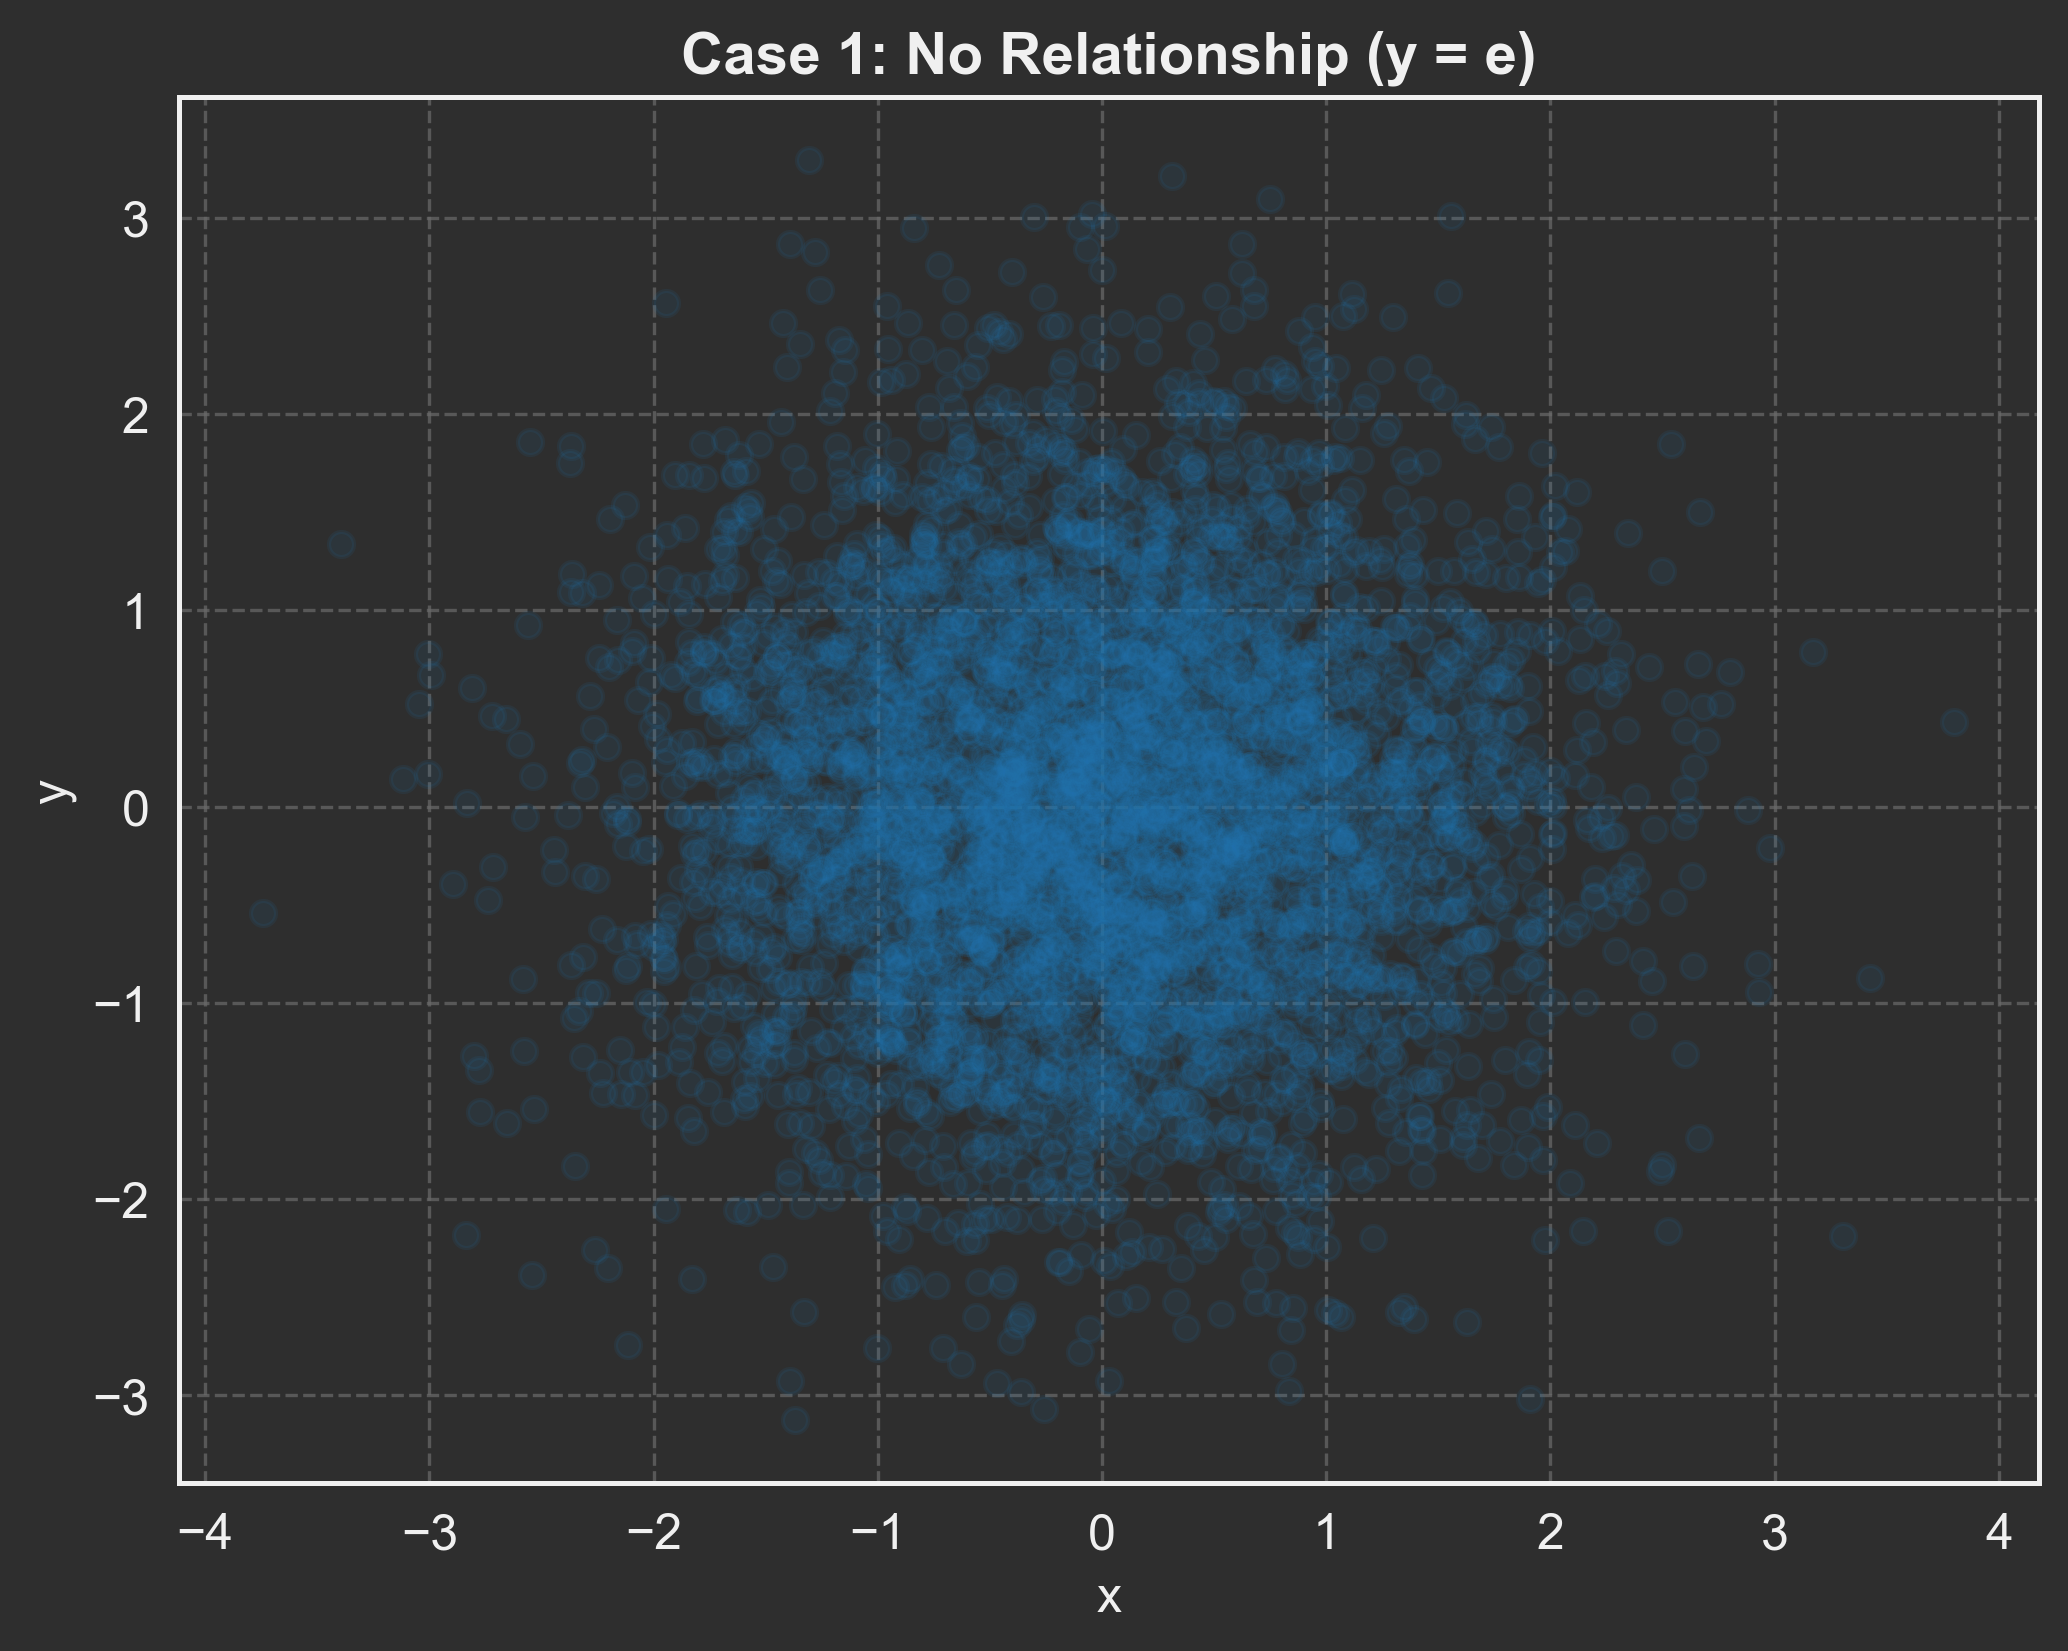

In [15]:
# y is independent of x
y_uncorr = 0*x_base + e_base

plot_mi_vs_corr(
    x_base, 
    y_uncorr, 
    "Case 1: No Relationship (y = e)", 
    "case1_no_relationship.png"
)

**Analysis:** As expected, both Correlation and Normalized MI are near zero.

### Case 2: Linear Relationship

Here, `y` has a strong, positive linear relationship with `x`.

Correlation:      0.9999
Normalized MI:    0.8907


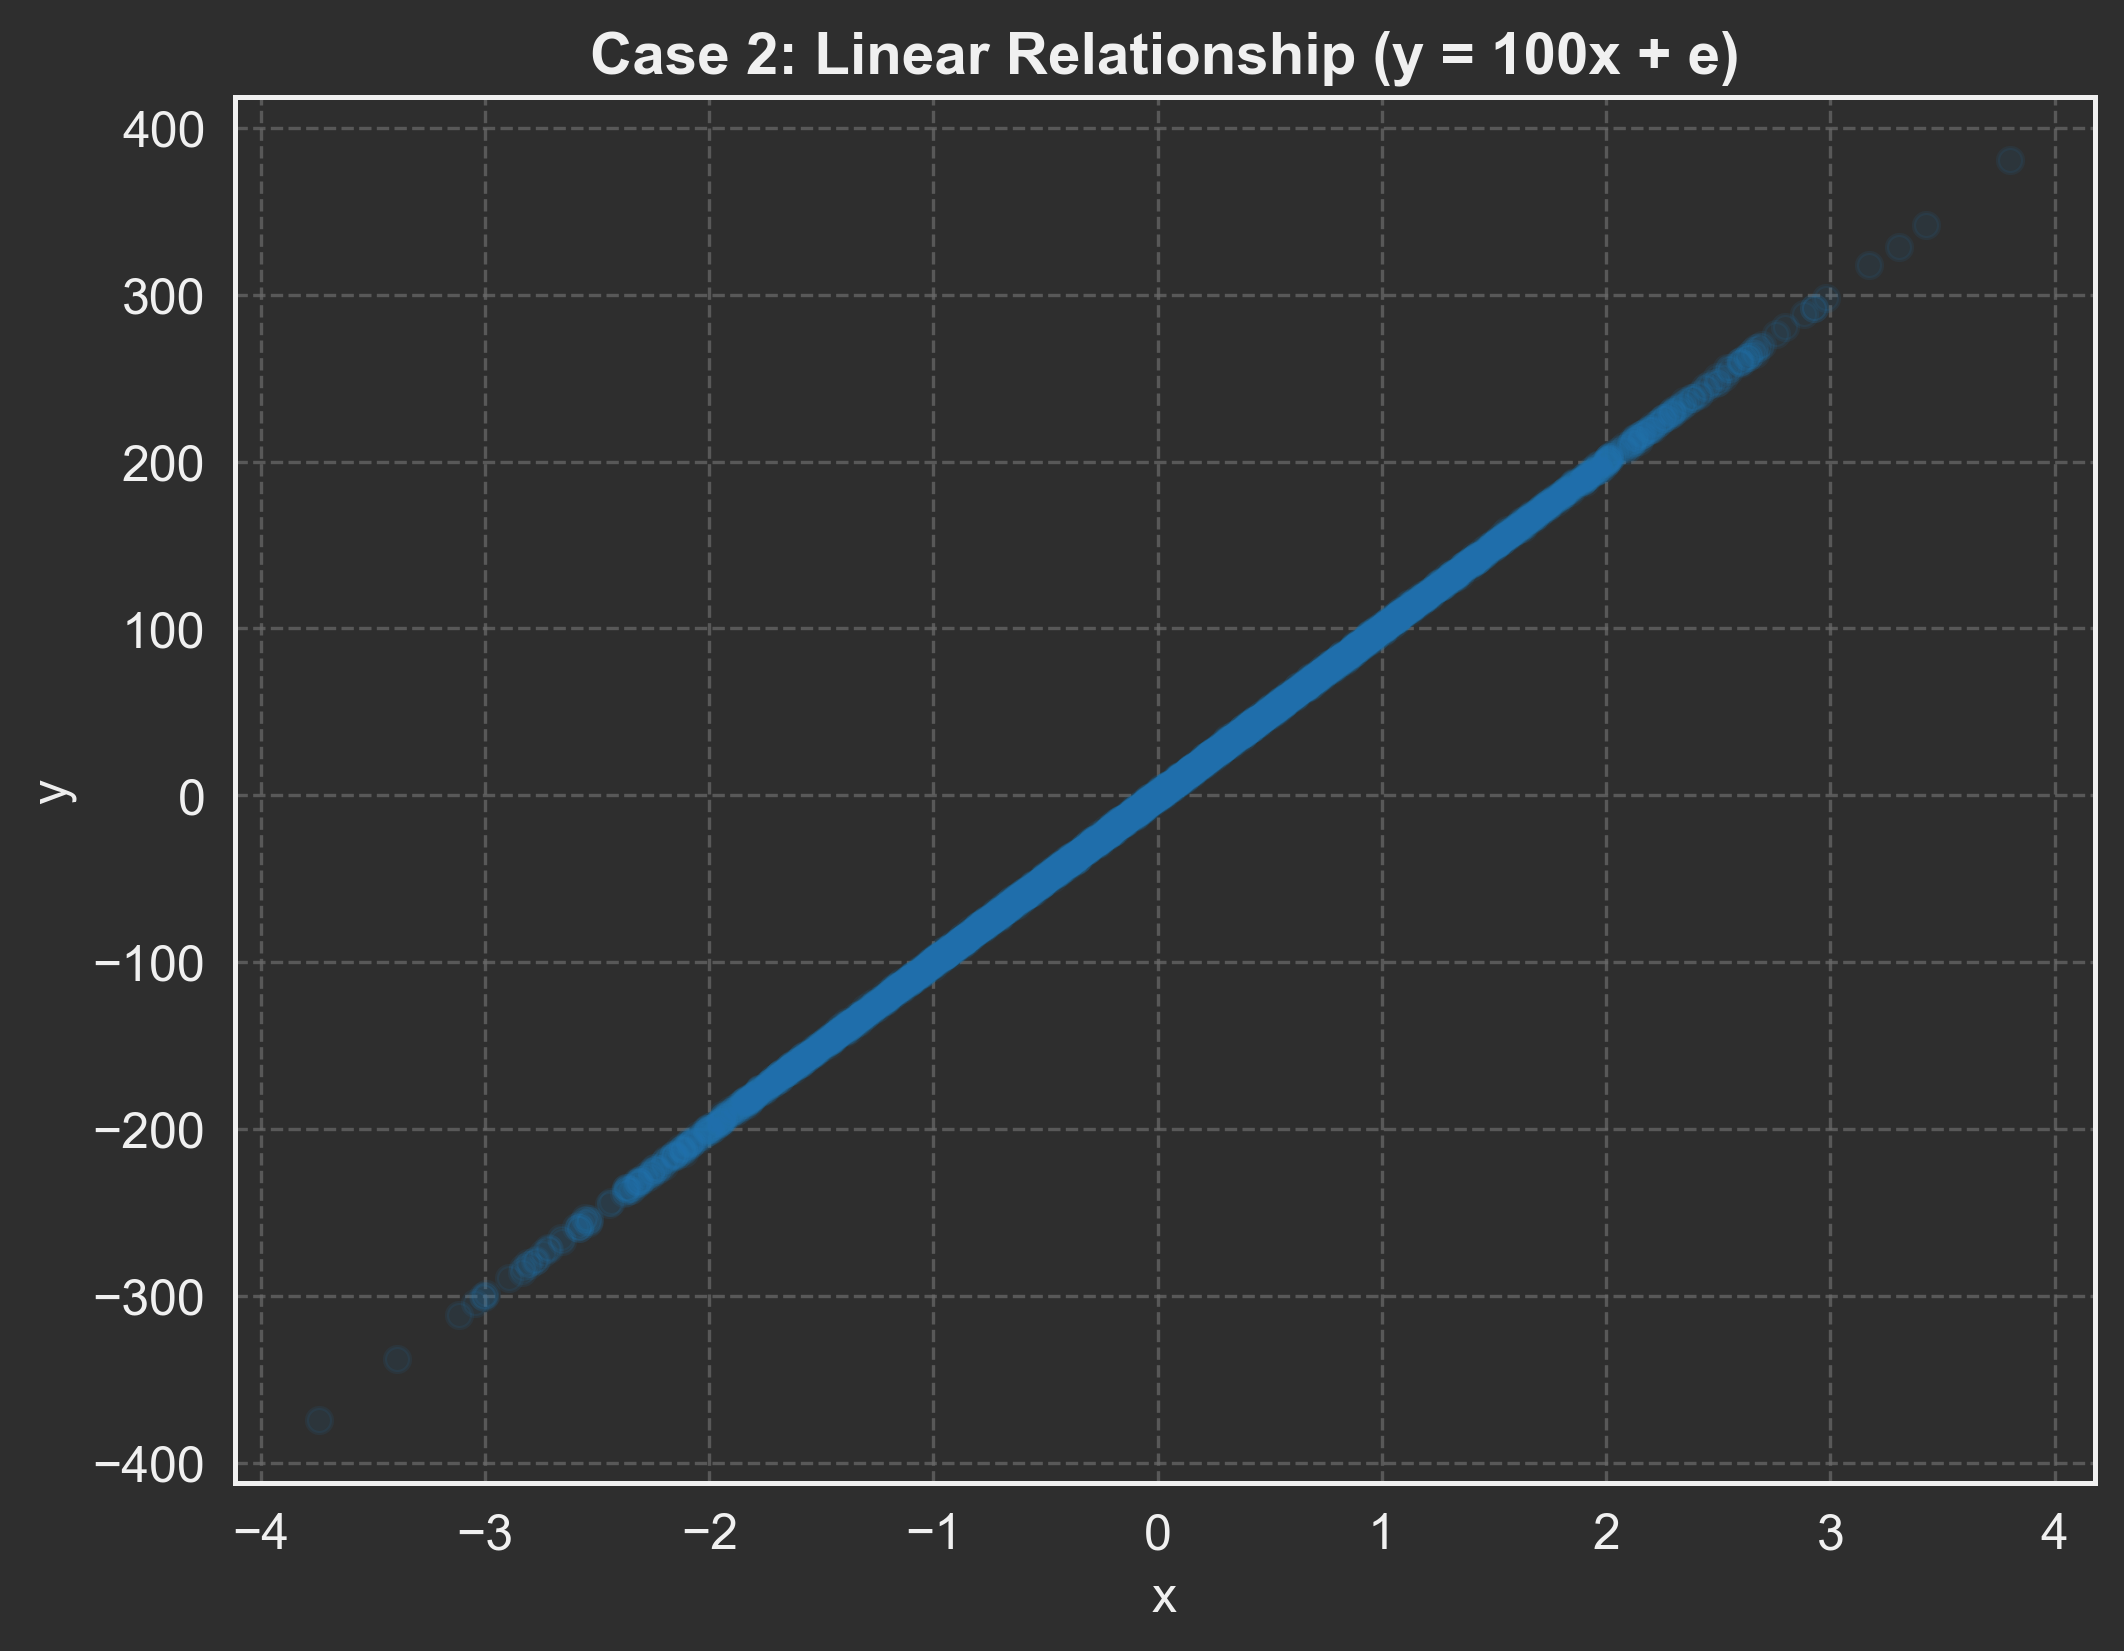

In [16]:
# y has a strong linear relationship with x
y_linear = 100 * x_base + e_base

plot_mi_vs_corr(
    x_base, 
    y_linear, 
    "Case 2: Linear Relationship (y = 100x + e)", 
    "case2_linear_relationship.png"
)

**Analysis:** Both metrics are near 1.0, correctly identifying the strong linear relationship.

### Case 3: Non-Linear Relationship

This is the key test. We define `y` as a "V-shape" function of `x` (`y = 100*abs(x)`). This is a strong, predictable relationship, but it is not linear.

Correlation:      -0.0080
Normalized MI:    0.6439


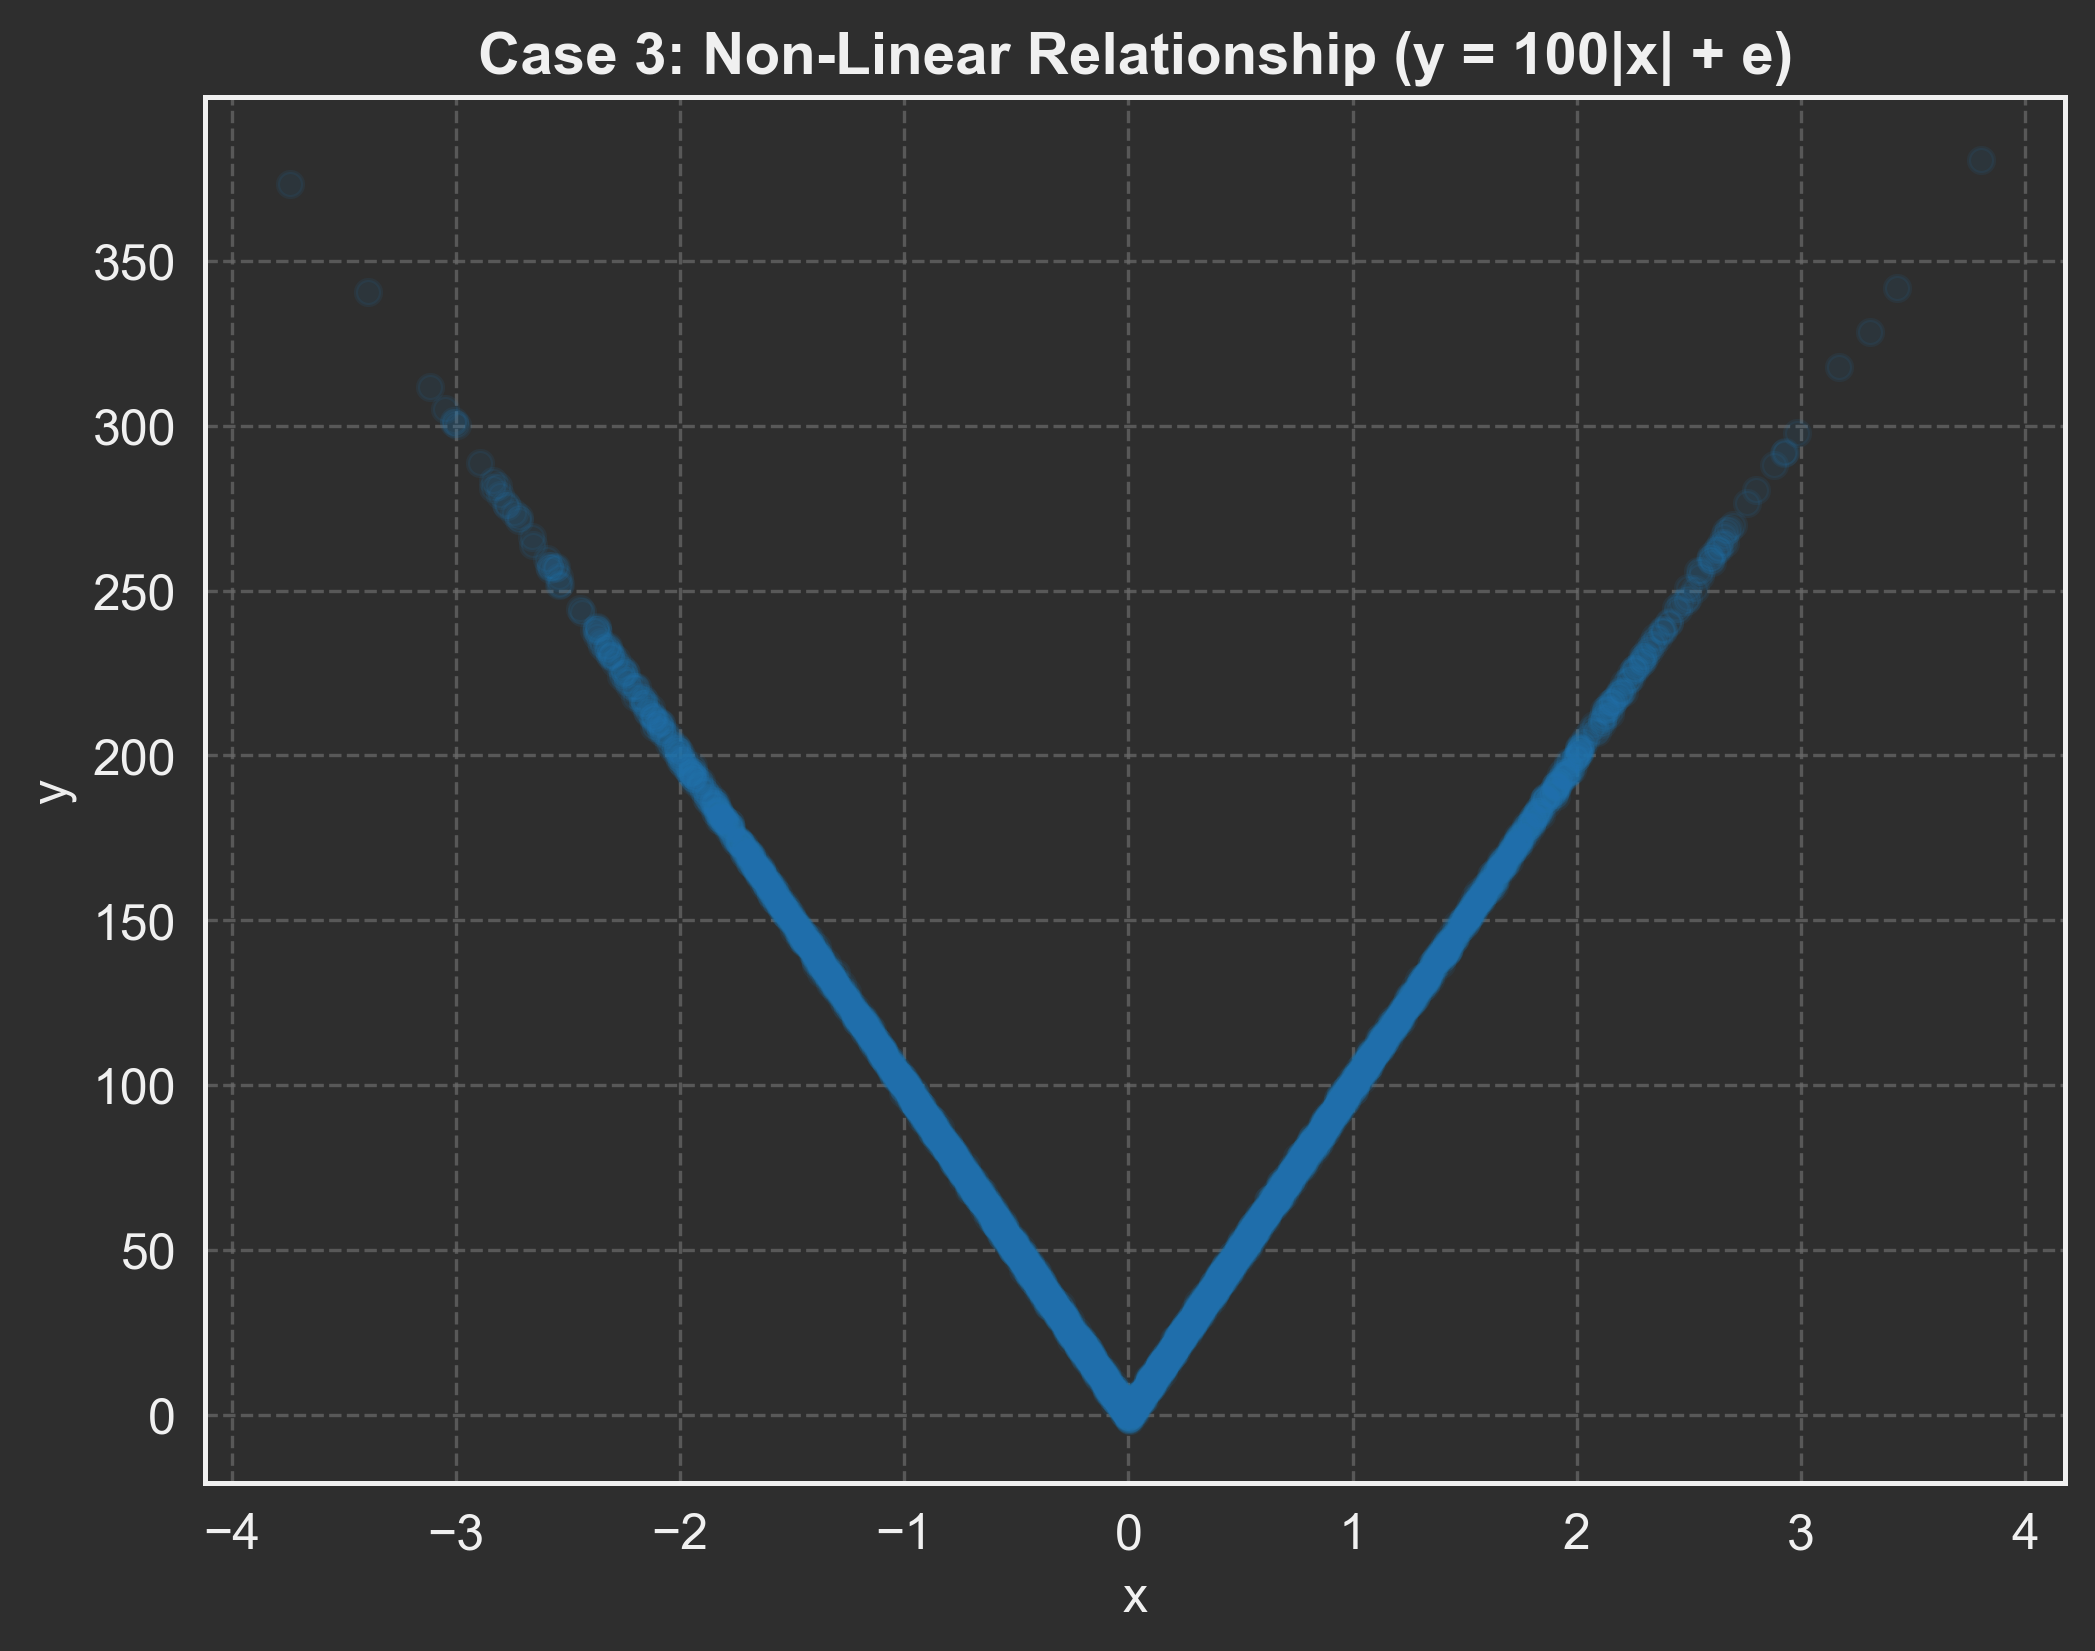

In [17]:
# y has a strong NON-LINEAR relationship with x
y_nonlinear = 100 * abs(x_base) + e_base

plot_mi_vs_corr(
    x_base, 
    y_nonlinear, 
    "Case 3: Non-Linear Relationship (y = 100|x| + e)", 
    "case3_nonlinear_relationship.png"
)

## 4. Angular Distance Matrix

Finally, let's demonstrate a different kind of metric: **Angular Distance**. This is not for comparing two variables, but for building a *distance matrix* from a *correlation matrix*. This is a key step for clustering algorithms (like HRP).

We'll load four different economic series to build a meaningful matrix.

In [18]:
# Load 4 series for a matrix
gdp_s = fred.get_series('GDP').resample('Q').last().dropna()
unrate_s = fred.get_series('UNRATE').resample('Q').mean().dropna()
sp500_s = fred.get_series('SP500').resample('Q').last().dropna()
dgs10_s = fred.get_series('DGS10').resample('Q').mean().dropna()

# Align all four
data_matrix = pd.DataFrame({
    'GDP': gdp_s,
    'UNRATE': unrate_s,
    'SP500': sp500_s,
    'DGS10': dgs10_s
}).dropna()

# Compute log returns, as distance metrics work better on stationary, scaled data
log_returns = np.log(data_matrix).diff().dropna()
print("Log Returns (Quarterly):")
print(log_returns.head())

# 1. Compute the correlation matrix
corr_matrix = log_returns.corr()
print("\nCorrelation Matrix:")
print(corr_matrix)

# 2. Compute the angular distance
dist_matrix = dm.calculate_distance(corr_matrix, metric='angular')
print("\nAngular Distance Matrix:")
print(dist_matrix)

Log Returns (Quarterly):
                 GDP    UNRATE     SP500     DGS10
2016-03-31  0.004913 -0.026847  0.007700 -0.134790
2016-06-30  0.009978  0.006780  0.018815 -0.089627
2016-09-30  0.009623 -0.006780  0.032535 -0.112219
2016-12-31  0.010360 -0.027588  0.032024  0.312706
2017-03-31  0.009941 -0.042864  0.053860  0.134512

Correlation Matrix:
             GDP    UNRATE     SP500     DGS10
GDP     1.000000 -0.906907 -0.081613  0.558824
UNRATE -0.906907  1.000000  0.202833 -0.597278
SP500  -0.081613  0.202833  1.000000 -0.185358
DGS10   0.558824 -0.597278 -0.185358  1.000000

Angular Distance Matrix:
             GDP    UNRATE     SP500     DGS10
GDP     0.000000  0.976450  0.735394  0.469670
UNRATE  0.976450  0.000000  0.631336  0.893667
SP500   0.735394  0.631336  0.000000  0.769857
DGS10   0.469670  0.893667  0.769857  0.000000
